## **Setup and Imports**

In [ ]:
# Install dependencies (if not already available in Colab)
!pip install torch torchvision statsmodels matplotlib pandas scikit-learn

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


## **Load Dataset**

          time  value
0  1949.000000    112
1  1949.083333    118
2  1949.166667    132
3  1949.250000    129
4  1949.333333    121


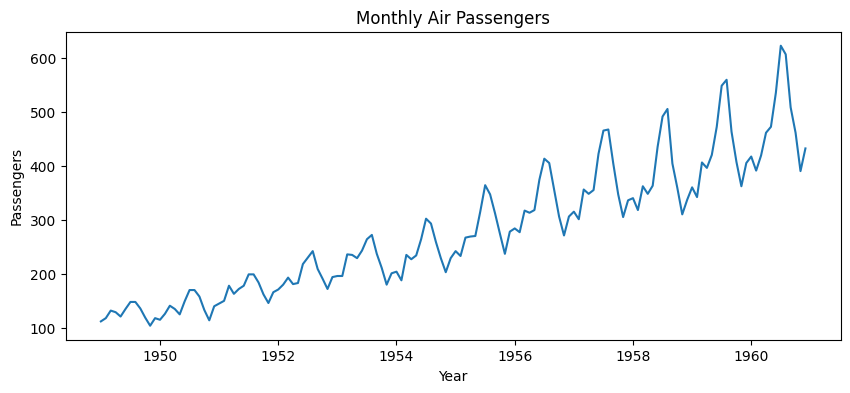

In [ ]:
from statsmodels.datasets import get_rdataset

# Load the AirPassengers dataset
data = get_rdataset('AirPassengers', package='datasets').data

# Display first few rows
print(data.head())

# Plot data
plt.figure(figsize=(10,4))
plt.plot(data['time'], data['value'])
plt.title('Monthly Air Passengers')
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.show()


## **Data Preprocessing**

In [ ]:
# Extract passenger counts
series = data['value'].values.reshape(-1, 1)

# Normalize data to [0,1]
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

# Create sequences for time series prediction
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LEN = 12  # past 12 months → predict next month
X, y = create_sequences(series_scaled, SEQ_LEN)

# Train-test split (80-20)
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=16, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=16, shuffle=False)

print(f"Train sequences: {len(X_train)}, Test sequences: {len(X_test)}")


Train sequences: 105, Test sequences: 27


## **Define RNN, LSTM, GRU Models**

In [ ]:
# Base RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# GRU Model
class GRUModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])


## **Training Function**

In [ ]:
def train_model(model, train_loader, epochs=30, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss / len(train_loader))
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {losses[-1]:.6f}")
    return losses


## **Train Each Model**

In [ ]:
# Train RNN
rnn = RNNModel()
rnn_losses = train_model(rnn, train_loader)

# Train LSTM
lstm = LSTMModel()
lstm_losses = train_model(lstm, train_loader)

# Train GRU
gru = GRUModel()
gru_losses = train_model(gru, train_loader)


Epoch [5/30], Loss: 0.020507
Epoch [10/30], Loss: 0.011168
Epoch [15/30], Loss: 0.006111
Epoch [20/30], Loss: 0.004756
Epoch [25/30], Loss: 0.004757
Epoch [30/30], Loss: 0.004408
Epoch [5/30], Loss: 0.023222
Epoch [10/30], Loss: 0.015279
Epoch [15/30], Loss: 0.012477
Epoch [20/30], Loss: 0.007081
Epoch [25/30], Loss: 0.006918
Epoch [30/30], Loss: 0.006534
Epoch [5/30], Loss: 0.022766
Epoch [10/30], Loss: 0.015368
Epoch [15/30], Loss: 0.007590
Epoch [20/30], Loss: 0.006192
Epoch [25/30], Loss: 0.005340
Epoch [30/30], Loss: 0.005930


## **Plot Training Loss**

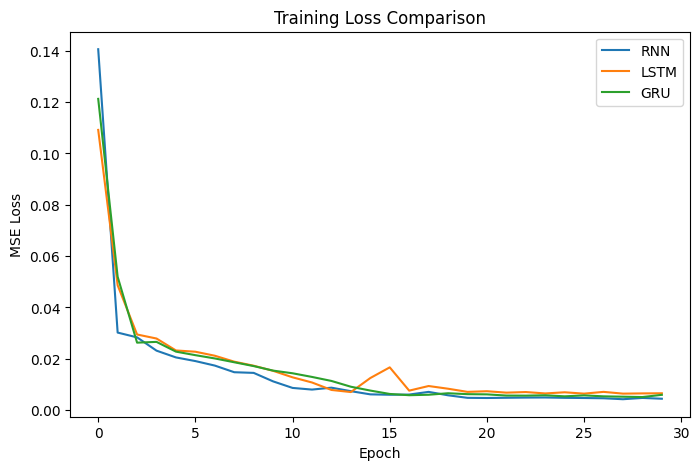

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(rnn_losses, label='RNN')
plt.plot(lstm_losses, label='LSTM')
plt.plot(gru_losses, label='GRU')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


## **Evaluation Function**

In [ ]:
def evaluate_model(model, X_test_t, y_test_t, scaler):
    model.eval()
    with torch.no_grad():
        preds = model(X_test_t).numpy()
    true = y_test_t.numpy()

    # Inverse transform to original scale
    preds_inv = scaler.inverse_transform(preds)
    true_inv = scaler.inverse_transform(true)

    rmse = sqrt(mean_squared_error(true_inv, preds_inv))
    return preds_inv, true_inv, rmse


## **Evaluate and Compare**

RNN RMSE : 68.09
LSTM RMSE: 81.81
GRU RMSE : 66.06


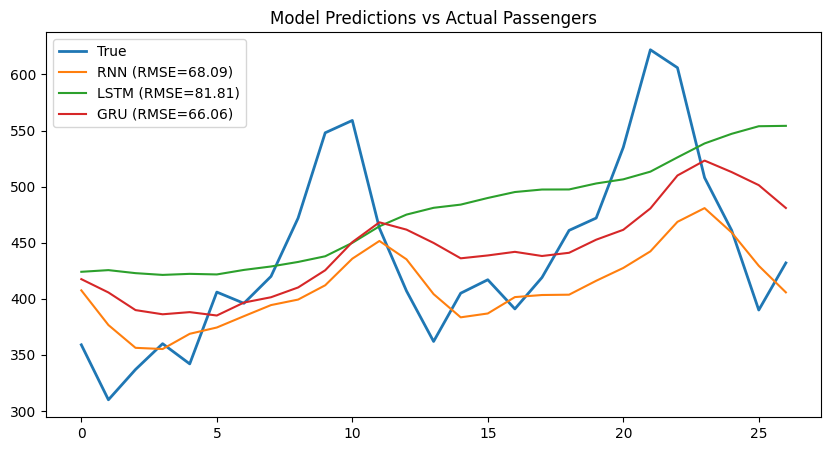

In [ ]:
rnn_preds, y_true, rnn_rmse = evaluate_model(rnn, X_test_t, y_test_t, scaler)
lstm_preds, _, lstm_rmse = evaluate_model(lstm, X_test_t, y_test_t, scaler)
gru_preds, _, gru_rmse = evaluate_model(gru, X_test_t, y_test_t, scaler)

print(f"RNN RMSE : {rnn_rmse:.2f}")
print(f"LSTM RMSE: {lstm_rmse:.2f}")
print(f"GRU RMSE : {gru_rmse:.2f}")

# Plot predictions vs true values
plt.figure(figsize=(10,5))
plt.plot(y_true, label='True', linewidth=2)
plt.plot(rnn_preds, label=f'RNN (RMSE={rnn_rmse:.2f})')
plt.plot(lstm_preds, label=f'LSTM (RMSE={lstm_rmse:.2f})')
plt.plot(gru_preds, label=f'GRU (RMSE={gru_rmse:.2f})')
plt.title('Model Predictions vs Actual Passengers')
plt.legend()
plt.show()
